In [1]:
import numpy as np
import magpylib as magpy
import matplotlib.pyplot as plt
import plotly.io as pio
from scipy.spatial.transform import Rotation as R

In [2]:
# =============================================================================
# Creating permanent bar magnet system for quadrupole field 
# =============================================================================

# Geometry of magnet positions within each corner (3 magnet locations)
magnet_offsets = [(17e-3, 17e-3), (18.293e-3, 19.707e-3),(19.707e-3, 18.293e-3)]

# Magnet dimensions and strength
x_l, y_l, z_l = 1.5e-3, 1e-3, 5e-3
M = 1074295  # N45 Neodymium

# Z offset per layer
z_offset = 5e-3  # 5 mm

# Corner rotations
rot_top_right   = R.from_euler('z',  45, degrees=True)
rot_top_left    = R.from_euler('z', 315, degrees=True)
rot_bottom_left = R.from_euler('z',  45, degrees=True)
rot_bottom_right= R.from_euler('z', 315, degrees=True)

The first part of the code is where you set up physical parameters

The offsets are the distances of the centre of the magnets in x and y from the centre of the assembly. So if you want to change the spacing of the magnets to reduce or increase  the gradient, change these values.

In the next part you can chnage the dimensions of the magnets.

the z_offset is just the distance each stacked magnet is from the one below it. This is here to allow stacking of the magnets without them overlapping. This needs to be changed to match the length of the magnets you are simulating

The rotations are defined with the R.from_euler function. This is a scipy rotation object. This creates a rotation which you can apply to the magnets. There is more detail on this function in the MagPylib documentation. 

In [3]:
# =============================================================================
# Define layer configurations for each magnet in each corner
# Each corner contains 3 magnet positions, and each list defines
# the specific z-layers (indices) at which magnets are placed
# =============================================================================
heights = {
    "C1": [[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], [], []],  # top right
    "C2": [[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], [], []],  # top left
    "C3": [[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], [], []],  # bottom left
    "C4": [[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], [], []],  # bottom right
}


This is the section where you can program in the magnets. Each line is a stack of the magnets in each corner, with each value corresponding to a specific magnet along the z axis. You can build just one stack of 21 magnets in the example shown above. You can add another stack at each side of the magnet by inputting in the locations in the square brackets. These can put anywhere along the z axis. To achieve a quadrupole field each stack must by symetrical. 

In [4]:
# =============================================================================
# Utility function to build an individual stack at a given (x, y)
# and for specific z-layers
# =============================================================================
def build_custom_stack(x, y, sign_x, sign_y, rot, M_sign, z_layers):
    stack = magpy.Collection()
    for z_index in z_layers:
        m = magpy.magnet.Cuboid(
            dimension=(x_l, y_l, z_l),
            magnetization=(0, M_sign * M, 0),
            position=(sign_x * x, sign_y * y, z_index * z_offset)
        )
        m.rotate(rot, anchor=None)
        stack.add(m)
    return stack

This is a function which defines a vertical stack of magnets

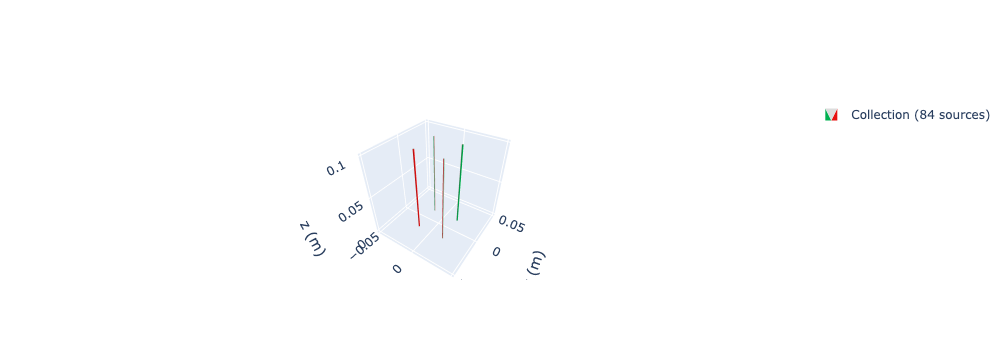

In [ ]:
# =============================================================================
# Function to build a full corner from 3 stacks
# =============================================================================
def build_corner(z_layer_lists, sign_x, sign_y, rot, M_sign):
    corner = magpy.Collection()
    for (x, y), z_layers in zip(magnet_offsets, z_layer_lists):
        stack = build_custom_stack(x, y, sign_x, sign_y, rot, M_sign, z_layers)
        corner.add(stack)
    return corner

# Build all four corners
Corner_1 = build_corner(heights["C1"], +1, +1, rot_top_right,   +1)
Corner_2 = build_corner(heights["C2"], -1, +1, rot_top_left,    +1)
Corner_3 = build_corner(heights["C3"], -1, -1, rot_bottom_left, -1)
Corner_4 = build_corner(heights["C4"], +1, -1, rot_bottom_right,-1)

# Combine all corners into one system
Full_Assembly = magpy.Collection(Corner_1, Corner_2, Corner_3, Corner_4)

# Visualize
Full_Assembly.show()

Function which assembles each corner of the assembly, consisting of 3 vertical magnet stacks which are offset slightly in x and y to allow them to sit back to back.

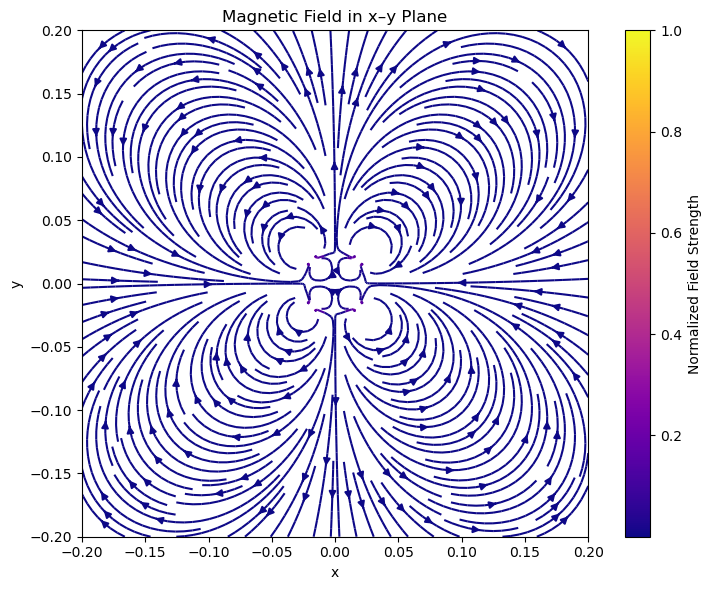

In [ ]:
# =============================================================================
# Calculating and plotting field components
# =============================================================================

# # =============================================================================
# # Vector plot for Magnetic Field in the x–y plane 
# # =============================================================================
 
 #Creating grid which will assign component to points in space
xy_ts = np.linspace(-200e-3, 200e-3, 100)
xy_grid = np.array([[(x, y, 0) for x in xy_ts] for y in xy_ts])  
X_xy, Y_xy, _ = np.moveaxis(xy_grid, 2, 0)
 
B_field_xy = Full_Assembly.getB(xy_grid)
B_x_xy, B_y_xy, _ = np.moveaxis(B_field_xy, 2, 0)
 
 #Computing magnitude
B_radial_xy = np.sqrt(B_x_xy**2 + B_y_xy**2)
B_radial_xy /= np.max(B_radial_xy) + 1e-12  
 
 #Plotting vector field
fig, ax = plt.subplots(figsize=(8, 6))
stream = ax.streamplot(X_xy, Y_xy, B_x_xy, B_y_xy, color=B_radial_xy, linewidth=1.5, density=2, cmap='plasma')
ax.set_aspect('equal')
ax.set_title('Magnetic Field in x–y Plane')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(stream.lines, ax=ax, label='Normalized Field Strength')
plt.tight_layout()
plt.show() 

This section of the code computes the radial field components and then visualises the field lines in the x-y plane. 

It uses the MagPylib command, getB to calculate the field at every point in a 2D linspace array. It then displays uses the streamplot command to plot these points as a vector field plot, with a colour bar which displays the magnitude of the field strength. 

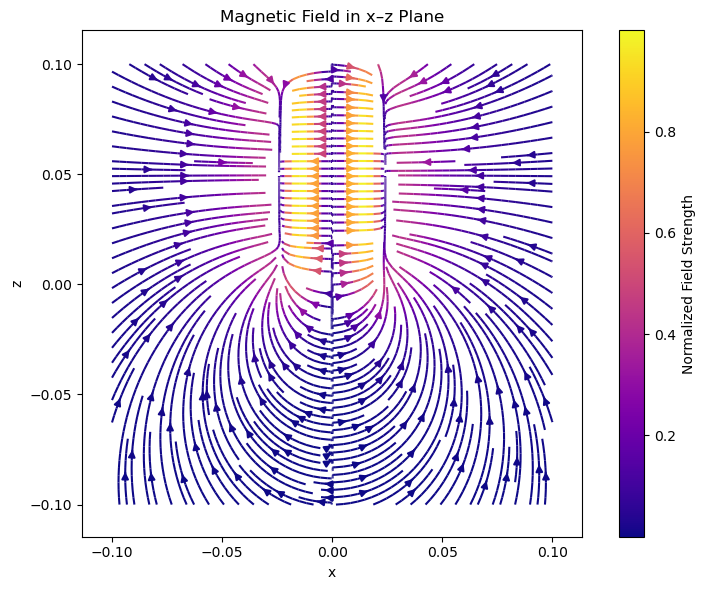

In [7]:
# =============================================================================
# # =============================================================================
# # Vector plot for Magnetic Field in the x–z plane 
# # =============================================================================

 #Creating grid which will assign component to points in space
xz_ts = np.linspace(-100e-3, 100e-3, 100)
xz_grid = np.array([[(x, 0, z) for x in xz_ts] for z in xz_ts])  # z = 0 plane
X_xz, _, Z_xz = np.moveaxis(xz_grid, 2, 0)
 
B_field_xz = Full_Assembly.getB(xz_grid)
B_x_xz, _, B_z_xz = np.moveaxis(B_field_xz, 2, 0)
 
 #Computing magnitude
B_radial_xz = np.sqrt(B_x_xz**2 + B_z_xz**2)
B_radial_xz /= np.max(B_radial_xz) + 1e-12  # normalize for colour map
 
 #Plotting vector field
fig, ax = plt.subplots(figsize=(8, 6))
stream = ax.streamplot(X_xz, Z_xz, B_x_xz, B_z_xz, color=B_radial_xz, linewidth=1.5, density=2, cmap='plasma')
ax.set_aspect('equal')
ax.set_title('Magnetic Field in x–z Plane')
ax.set_xlabel('x')
ax.set_ylabel('z')
plt.colorbar(stream.lines, ax=ax, label='Normalized Field Strength')
plt.tight_layout()
plt.show()

This section is exactly the same as previous, but visualising the field in the x-z plane.

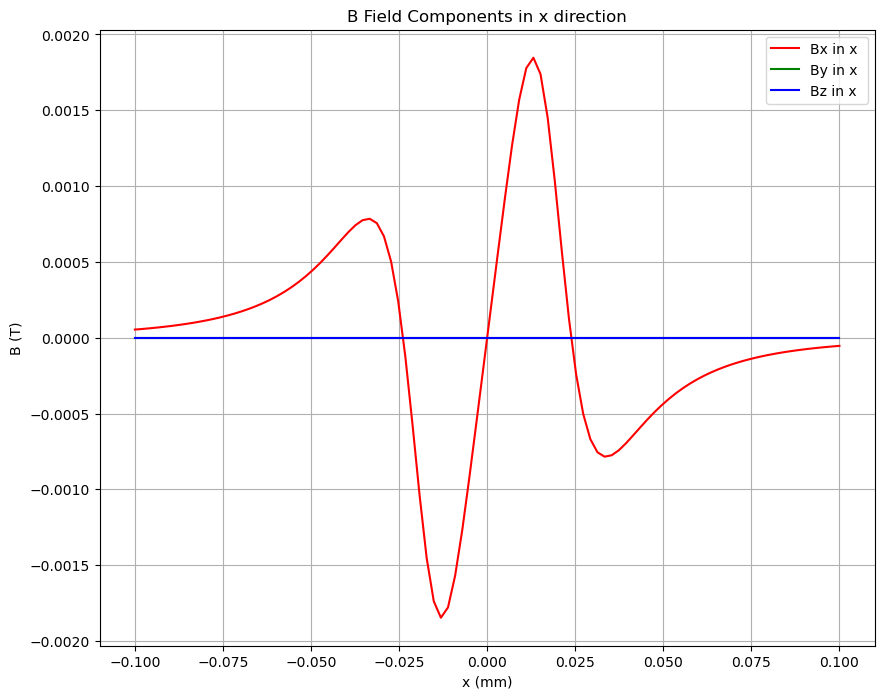

In [8]:
# =============================================================================
# Plotting X component of B with y = 0 and z = 0
# =============================================================================

#Creating line for measuremtn of B components along x 
x_ts = np.linspace(-100e-3, 100e-3, 100)
x_measurement_line = np.array([[x, 0, 50e-3] for x in x_ts])   ###!!! Z needs to be 5e-3 if you have a stack of two on top pf each pther, this changes the measurment line to the correct psoition to preserve symetry
#47.5e-3 for 20 stack of these magnets
#x,y and z B components along the x axis
B_forgraph_x = Full_Assembly.getB(x_measurement_line)

#Spliced array so it contains just the x components; 100, 1 dimension array
B_x_spliced_in_x = B_forgraph_x[:, 0]
#B_amp_z = np.linalg.norm(B_z_spliced, axis=0)

#Spliced array so it contains just the y components; 100, 1 dimension array
B_y_spliced_in_x = B_forgraph_x[:, 1]

#Spliced array so it contains just the z components; 100, 1 dimension array
B_z_spliced_in_x = B_forgraph_x[:, 2]

#Creating Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8) , sharex=True)
ax.plot(x_ts, B_x_spliced_in_x, label = 'Bx in x', color = 'r')
ax.plot(x_ts, B_y_spliced_in_x, label = 'By in x ', color = 'g')
ax.plot(x_ts, -B_z_spliced_in_x, label = 'Bz in x', color = 'b')

ax.set_ylabel('B (T)')
ax.set_xlabel('x (mm)')
ax.set_title('B Field Components in x direction')
ax.grid(True)
ax.legend()

Here, you can plot the field components against the radial axis. The get.B commnand computes and assigns the field at every point along a 1D linspace array. This creates a 3 coloumn array of the Bx, By and Bz components, respectively. This array is then spliced and plotted against the linspace array. You can change the y axis to be in units of Gauss by multiplying the components by 10000.

This line is centred halfway up the magnet assembly. The z portion of the x_measurement_line part needs to be altered depending on how tall your magnet stack is. In this example the magnet stack is 21 magnets. Intially, the line will be halfway through the magnet that is at the 0 indice point. This is because MagPylib builds magnets symetric about the x-y plane. 

A general rule is this: ((Number of Magnets in Stack * Length of Magnet)/2)-(Length of Magnet/2). This ensures being able to get the field strength at the centre of the assembly. Later on in the code a plot will be made of the consistency of the field over the full length of the assembly.

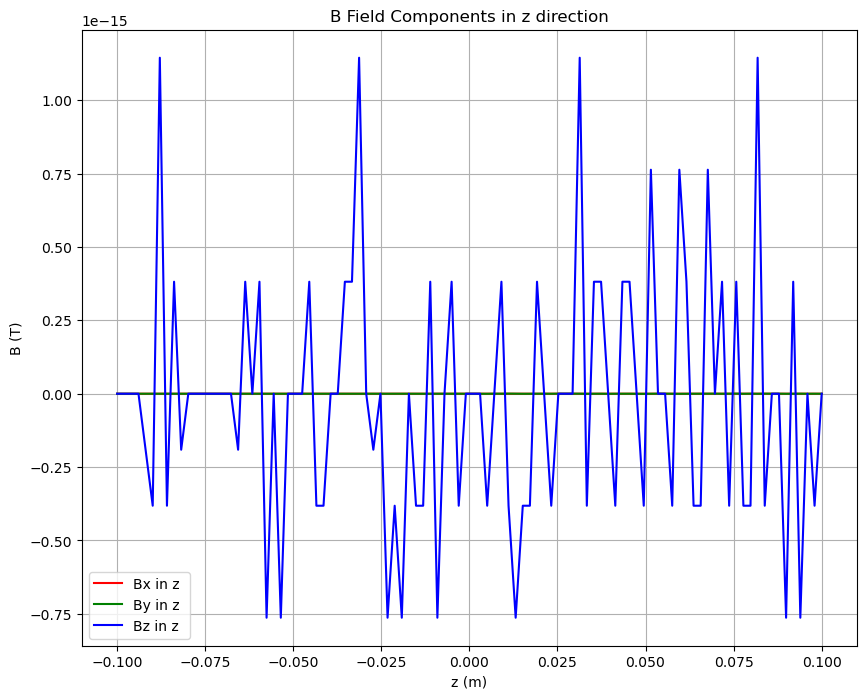

In [9]:
#Creating line for measurement for B components along z axis
z_ts = np.linspace(-100e-3, 100e-3, 100)
z_measurement_line = np.array([[0, 0, z] for z in z_ts]) 

#Calculating x, y and z components of B field along z axis
B_forgraph_z = Full_Assembly.getB(z_measurement_line)

#Spliced array so it contains just the x components; 100, 1 dimension array
B_x_spliced_in_z = B_forgraph_z[:, 0]

#Spliced array so it contains just the y components; 100, 1 dimension array
B_y_spliced_in_z = B_forgraph_z[:, 1]

#Spliced array so it contains just the z components; 100, 1 dimension array
B_z_spliced_in_z = B_forgraph_z[:, 2]

#Creating Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8) , sharex=True)
ax.plot(z_ts, B_x_spliced_in_z, label = 'Bx in z', color = 'r')
ax.plot(z_ts, B_y_spliced_in_z, label = 'By in z ', color = 'g')
ax.plot(z_ts, B_z_spliced_in_z, label = 'Bz in z', color = 'b')

ax.set_ylabel('B (T)')
ax.set_xlabel('z (m)')
ax.set_title('B Field Components in z direction')
ax.grid(True)
ax.legend()

This section is the same as the previous one, it just calculates the field components along the axial direction. No altercations need to be made to the measurement line here. 

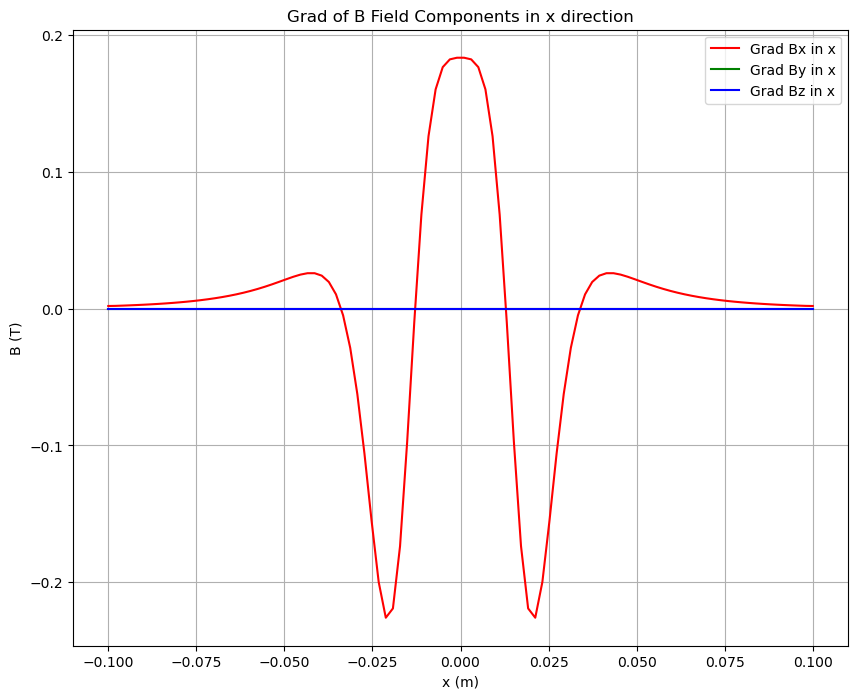

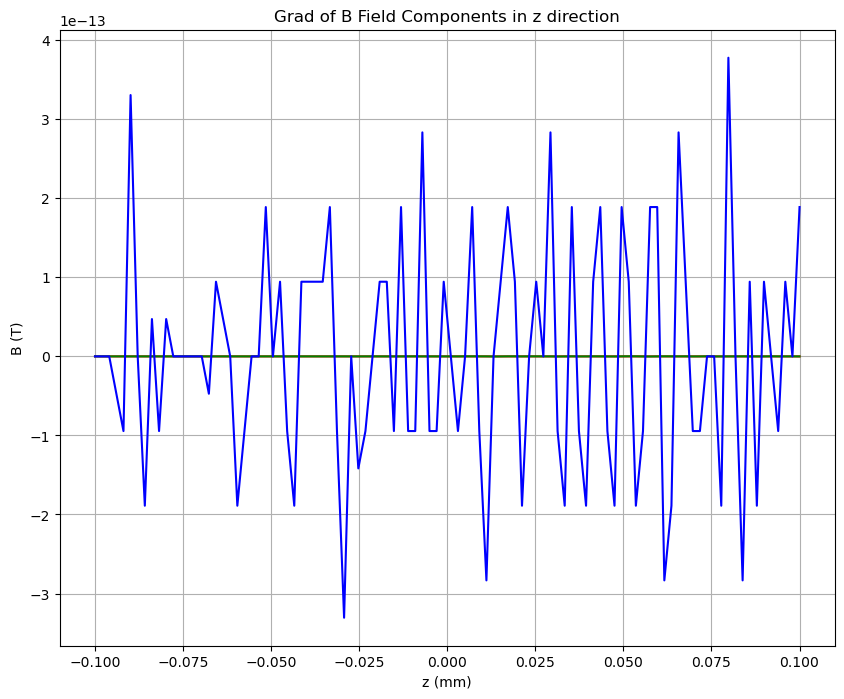

In [10]:
# =============================================================================
# Calculating and graphing the gradients of the B Components
# =============================================================================

#Radial Direction

dx = x_ts[99] - x_ts[98]

#Calculating gradient of Bx in x, y and z
Grad_Bx_in_x = np.gradient(B_x_spliced_in_x, dx )
Grad_By_in_x = np.gradient(B_y_spliced_in_x, dx)
Grad_Bz_in_x = np.gradient(B_z_spliced_in_x, dx)


#Plotting these along x linspace array
fig, ax = plt.subplots(1, 1, figsize=(10, 8) , sharex=True)
ax.plot(x_ts, Grad_Bx_in_x, label = 'Grad Bx in x', color = 'r')
ax.plot(x_ts, Grad_By_in_x, label = 'Grad By in x', color = 'g')
ax.plot(x_ts, Grad_Bz_in_x, label = 'Grad Bz in x', color = 'b')

ax.set_ylabel('B (T)')
ax.set_xlabel('x (m)')
ax.set_title('Grad of B Field Components in x direction')
ax.grid(True)
ax.legend()

#Axial Direction

dz = z_ts[99]-z_ts[98]

#Calculating gradient of Bz in x, y and z direction
Grad_Bx_in_z = np.gradient(B_x_spliced_in_z, dz)
Grad_By_in_z = np.gradient(B_y_spliced_in_z, dz)
Grad_Bz_in_z = np.gradient(B_z_spliced_in_z, dz)

#Plotting aginst z linspace array
fig, ax = plt.subplots(1, 1, figsize=(10, 8) , sharex=True)
ax.plot(z_ts, Grad_Bx_in_z, label = 'Grad Bx in z', color = 'r')
ax.plot(z_ts, Grad_By_in_z, label = 'Grad By in z', color = 'g')
ax.plot(z_ts, Grad_Bz_in_z, label = 'Grad Bz in z', color = 'b')

ax.set_ylabel('B (T)')
ax.set_xlabel('z (mm)')
ax.set_title('Grad of B Field Components in z direction')
ax.grid(True)

This section is similar to the previous two, apart from the fact that the gradient of the field components are computed and plotted against the linspace arrays.

In [11]:
# Find max gradient in T/mm
Max_Grad_Bx_in_x = np.max(Grad_Bx_in_x)
Max_Grad_Bz_in_z = np.max(Grad_Bz_in_z)
Max_Grad_Bx_in_z = np.max(Grad_Bx_in_z)
Max_Grad_Bz_in_x = np.max(Grad_Bz_in_x)

# Convert to G/cm: (T → G is x10⁴, mm → cm is ÷0.1 → x10)
#max_gradient_G_per_cm = Max_Grad_Bx_in_x * 1e4 * 10

# Print result
#print(f"Maximum gradient: {Max_Grad_Bx_in_x:.6e} T/mm")
#print(f"Converted to: {max_gradient_G_per_cm:.2f} G/cm")

# Value in Tesla per meter
gradient_T_per_m = Max_Grad_Bx_in_x
Gradient_of_Bz_inz_inT_m = Max_Grad_Bz_in_z
Gradient_of_Bx_inz_inT_m = Max_Grad_Bx_in_z
Gradient_of_Bz_inx_inT_m = Max_Grad_Bz_in_x

# Conversion factor: 1 T/m = 100 G/cm
conversion_factor = 1e4/100

# Convert to Gauss per centimeter
gradient_Bx_inx_G_per_cm = gradient_T_per_m * conversion_factor
gradient_Bz_inz_G_per_cm = Gradient_of_Bz_inz_inT_m * conversion_factor
gradient_Bx_inz_G_per_cm = Gradient_of_Bx_inz_inT_m * conversion_factor
gradient_Bz_inx_G_per_cm = Gradient_of_Bz_inx_inT_m * conversion_factor 


# Print the result
print(f"Magnetic field gradient of Bx in x: {gradient_Bx_inx_G_per_cm:.4f} G/cm")
print(f"Magnetic Field Gradient of Bz in z: {gradient_Bz_inz_G_per_cm:.4f} G/cm")
print(f"Magnetic Field Gradient of Bx in z: {gradient_Bx_inz_G_per_cm:.4f} G/cm")
print(f"Magnetic Field Gradient of Bz in x: {gradient_Bz_inx_G_per_cm:.4f} G/cm")

Magnetic field gradient of Bx in x: 18.3426 G/cm
Magnetic Field Gradient of Bz in z: 0.0000 G/cm
Magnetic Field Gradient of Bx in z: 0.0000 G/cm
Magnetic Field Gradient of Bz in x: 0.0000 G/cm


This section converts the maximum gradient values in the 1D array from T/m to G/cm. It then prints all of these values in the console. This helps when you are doing trial and error with the magnet dimensions to give you quick and easy values for the max gradients.

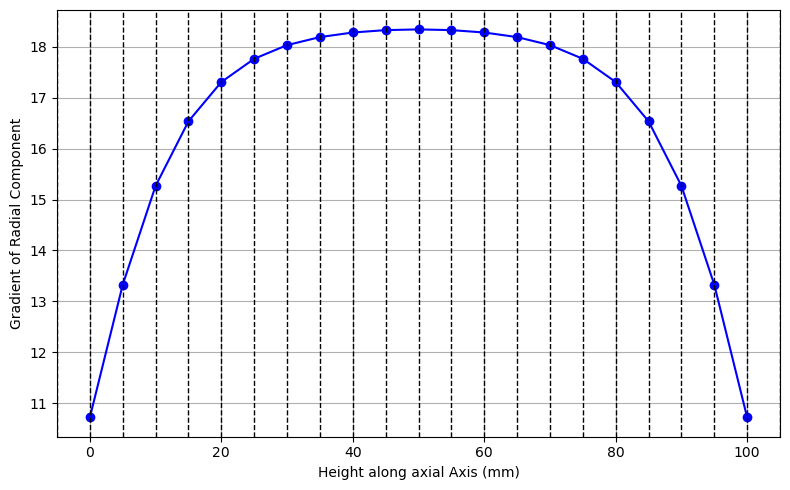

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import magpylib as mag

# Define x-axis sampling
x_range = np.linspace(-0.1, 0.1, 100)  # 10 cm span along x
dx = x_range[99] - x_range[98]             # spacing for np.gradient
y_val = 0                                # fixed y

# Define z values to sample (from 0 mm to 50 mm in 5 mm steps)
z_vals = np.arange(0, 0.105, 0.005)      # in meters

# Store central gradients for each height
central_gradients = []

for z in z_vals:
    # Define positions along x at fixed y and current z
    positions = np.array([[x, y_val, z] for x in x_range])
    
    # Get B field at each point
    B = mag.getB(Full_Assembly, positions)
    Bx = B[:, 0]  # x-component of B field

    # Compute gradient of Bx with respect to x
    dBxdx = np.gradient(Bx, dx)*100

    # Take the gradient at x=0 (i.e. center of array)
    mid_index = len(x_range) // 2
    central_gradients.append(dBxdx[mid_index])
    

# Plot central gradient vs height z
plt.figure(figsize=(8, 5))
plt.plot(z_vals * 1000, central_gradients, marker='o', color='blue')
plt.xlabel("Height along axial Axis (mm)")
plt.ylabel("Gradient of Radial Component")
for mm in range(-5, 110, 5):
    plt.axvline(x=mm, color='k', linestyle='--', linewidth=1)
plt.grid(True)
plt.tight_layout()
plt.show()

This section of the code essentially computes the consistency of the gradient along the length of the magnet assembly. It calculates the radial componets gradient with respect the its position in the radial direction, at each point along the axial axis (so at each point along the length of the assembly) It calculates the field along a 1D line, the same as previous sections, but it does this at multiple heights along the z axis (multiple heights of the assembly). With this current setup you can see the gradient falls off as you move away from the centre of the assembly. In this example, there is measurement lines in line with the centre of each of the magnets; this allows you to see how adding a magnet at a specific point effects the gradient at that specific point.